# Compte-Rendu de Travail :

In [1039]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import sklearn.metrics as met
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso

J'ai commencé par fusionner les différents csv, pour pouvoir travailler sur un seul et même fichier, grâce à la commande :
                                    // cat *.csv > combined.csv //

In [1040]:
data = pd.read_csv('csv/combined.csv', sep=';')
print(data)

       id_mutation date_mutation  numero_disposition nature_mutation  \
0      2022-360375    21/04/2022                   1           Vente   
1      2022-360375    21/04/2022                   1           Vente   
2     2021-1180016    10/05/2021                   1           Vente   
3     2021-1177880    14/01/2021                   1           Vente   
4     2021-1177880    14/01/2021                   1           Vente   
...            ...           ...                 ...             ...   
2967  2019-1112209    11/02/2019                   1           Vente   
2968  2018-1037104    28/12/2018                   1           Vente   
2969  2018-1037104    28/12/2018                   1           Vente   
2970  2018-1033451    04/07/2018                   1           Vente   
2971  2018-1033549    28/06/2018                   1           Vente   

      valeur_fonciere  adresse_numero adresse_suffixe  \
0            260000.0            26.0            None   
1            260000.0

On veut cibler directement les colonnes que l'on souhaite garder, qui nous semble pertinentes, pour cela on fait une matrice de corrélation :

C:\Users\simon\AppData\Local\Temp\ipykernel_76120\3562252322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat_corr = data.corr()


<AxesSubplot: >

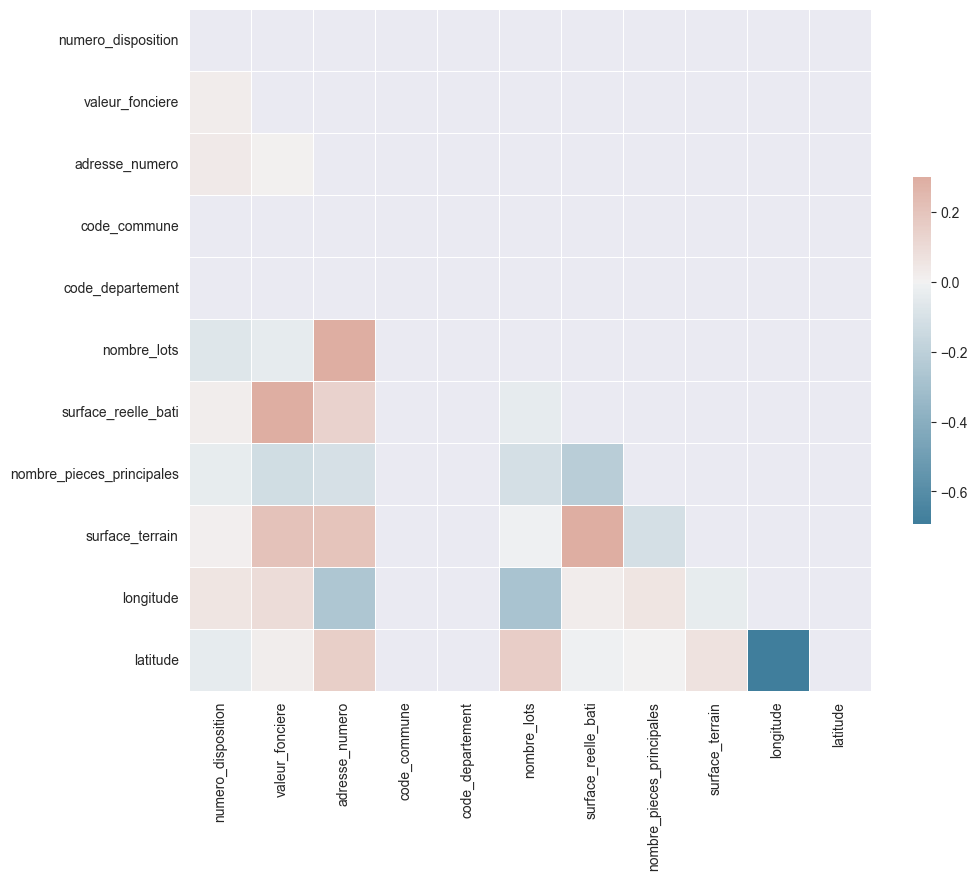

In [1041]:
mat_corr = data.corr()
mask = np.triu(np.ones_like(mat_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

On voit bien avec cette matrice, l'importance de chaque caractéristique. On peut donc enlever les non-pertinentes :

In [1042]:
data = data.drop(['code_postal', 'section_prefixe', 'id_parcelle', 'adresse_code_voie', 'adresse_nom_voie', 'date_mutation', 'adresse_suffixe', 'id_mutation', 'nature_mutation', 'code_commune', 'code_departement', 'nombre_lots', 'numero_disposition', 'code_commune', 'code_departement', 'nom_commune', 'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'code_type_local', 'code_nature_culture', 'code_nature_culture_speciale', 'nature_culture', 'nature_culture_speciale'], axis=1)
print(data)

      valeur_fonciere  adresse_numero  \
0            260000.0            26.0   
1            260000.0            26.0   
2            160000.0            13.0   
3            174000.0            21.0   
4            174000.0            21.0   
...               ...             ...   
2967          56460.0           620.0   
2968        1000000.0          9010.0   
2969        1000000.0          9010.0   
2970         165600.0             NaN   
2971         665000.0           165.0   

                                    type_local  surface_reelle_bati  \
0                                       Maison                129.0   
1                                   Dépendance                  NaN   
2                                       Maison                 64.0   
3                                       Maison                 64.0   
4                                   Dépendance                  NaN   
...                                        ...                  ...   
2967  Loca

Pour l'analyse des données, on réalise un changement en disant que :
'Maison' devient 0 et 'Appartment' devient 1
Car on veut estimer que ça.

In [1043]:
data.loc[data.type_local=='Maison','type_local']='0'
data.loc[data.type_local=='Appartement','type_local']='1'
data.loc[data.type_local=='Local industriel. commercial ou assimilé','type_local']=np.nan
data.loc[data.type_local=='DÃ©pendance','type_local']=np.nan
print(data)

      valeur_fonciere  adresse_numero  type_local  surface_reelle_bati  \
0            260000.0            26.0           0                129.0   
1            260000.0            26.0  Dépendance                  NaN   
2            160000.0            13.0           0                 64.0   
3            174000.0            21.0           0                 64.0   
4            174000.0            21.0  Dépendance                  NaN   
...               ...             ...         ...                  ...   
2967          56460.0           620.0         NaN              11002.0   
2968        1000000.0          9010.0           1                 87.0   
2969        1000000.0          9010.0         NaN               1048.0   
2970         165600.0             NaN        None                  NaN   
2971         665000.0           165.0         NaN                600.0   

      nombre_pieces_principales  surface_terrain  longitude   latitude  
0                           4.0       

On peut remarquer qu'il y a beaucoup de valeurs absentes, dans certaines colonnes. Comme elles n'apportent pas d'information, j'ai décidé de les retirer pour faciliter le traitement des données :

In [1044]:
data.dropna(inplace=True)
data = pd.DataFrame.reset_index(data, drop=True)
print(data)

      valeur_fonciere  adresse_numero type_local  surface_reelle_bati  \
0            260000.0            26.0          0                129.0   
1            160000.0            13.0          0                 64.0   
2            174000.0            21.0          0                 64.0   
3            200000.0             2.0          1                 18.0   
4            180000.0            28.0          0                108.0   
...               ...             ...        ...                  ...   
1233         145000.0            27.0          0                 74.0   
1234         262500.0             5.0          0                102.0   
1235         130000.0            25.0          0                 64.0   
1236         189300.0            20.0          0                 80.0   
1237        1000000.0          9010.0          1                 87.0   

      nombre_pieces_principales  surface_terrain  longitude   latitude  
0                           4.0            351.0  

Nous voilà avec un dataset propre et rangé. Regardons si tout est pris en compte :

<AxesSubplot: >

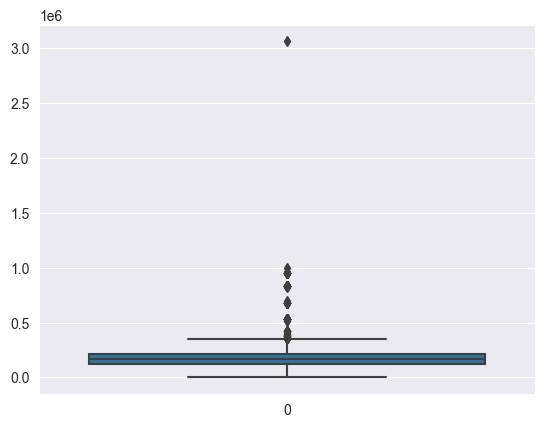

In [1045]:
sns.boxplot(data['valeur_fonciere'])

Ce graphique nous montre que tout n'est pas pris en compte et cela peut fausser notre prédiction.

In [1046]:
Q1 = np.percentile(data['valeur_fonciere'], 25, interpolation = 'midpoint')
Q3 = np.percentile(data['valeur_fonciere'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
Old_Shape=data.shape
upper = np.where(data['valeur_fonciere'] >= (Q3+ 32 * IQR))
lower = np.where(data['valeur_fonciere'] <= (Q1 - 1.3 * IQR))
data.drop(upper[0], inplace = True)
data.drop(lower[0], inplace = True)
New_Shape=data.shape

C:\Users\simon\AppData\Local\Temp\ipykernel_76120\4068398282.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(data['valeur_fonciere'], 25, interpolation = 'midpoint')
C:\Users\simon\AppData\Local\Temp\ipykernel_76120\4068398282.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(data['valeur_fonciere'], 75, interpolation = 'midpoint')


On peut donc voir que le nombre de données a diminué :

In [1047]:
print('Avant :', Old_Shape)
print('Après :', New_Shape)

Avant : (1238, 8)
Après : (1201, 8)


Après avoir nettoyé ces données, on va pouvoir les afficher :

In [1048]:
carte = folium.Map(location=[49.38, 1.085], zoom_start=13.1, tiles='stamenterrain')
points = folium.FeatureGroup(name='Points')

longitude = data.longitude.values
latitude = data.latitude.values
Val_Fonc = data.valeur_fonciere.values

for i in range(len(data)):
    folium.CircleMarker(
        location = [latitude[i], longitude[i]],
        fill = True,
        fill_opacity = 0.6,
        radius = 6
    ).add_to(points)


points.add_to(carte)

carte


On a pu représenter les données géographiquement. Représentons-les graphiquement maintenant :

In [1049]:
data_train, data_test = train_test_split(data, train_size=0.7, test_size=0.3, random_state=10)

In [1050]:
X_train = data_train
X_train = X_train.drop('valeur_fonciere', axis=1)
Y_train = data_train['valeur_fonciere']

In [1051]:
X_test = data_test
X_test = X_test.drop('valeur_fonciere', axis=1)
Y_test = data_test['valeur_fonciere']

Avec la méthode de régression linéaire :

In [1052]:
RegLin = LinearRegression()
scores = cross_val_score(RegLin, X_train, Y_train, cv=5)
print(scores)

[0.51538985 0.55329521 0.48392495 0.55657356 0.57799505]


Donc on a : Y = [-1.53420471e+01  3.40492965e+05  1.10834777e+03  2.35916834e+03
  8.60752762e+01  6.63519570e+05  1.20224955e+06] X + -60074359.051963925
0.6770457179323848


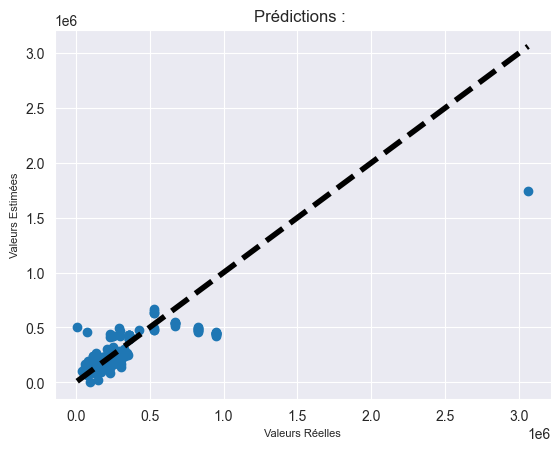

In [1053]:
RegLin.fit(X_train, Y_train)
Y_final = RegLin.predict(X_test)
r2 = met.r2_score(Y_test, Y_final)
a = RegLin.coef_
b = RegLin.intercept_
print('Donc on a : Y =', a, 'X +', b)
print(r2)


fig, ax = plt.subplots()
ax.scatter(Y_test, Y_final)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Valeurs Réelles', fontsize=8)
ax.set_ylabel('Valeurs Estimées', fontsize=8)
ax.set_title('Prédictions : ')
plt.show()

Avec la méthode Lasso :

In [1054]:
Lasso = Lasso()
scores = cross_val_score(Lasso, X_train, Y_train, cv=5)
print(scores)

[0.51520677 0.55326777 0.48390569 0.55731264 0.5778326 ]


Donc on a : Y = [-1.53772754e+01  3.40512441e+05  1.10689407e+03  2.38287971e+03
  8.59706978e+01  6.34899281e+05  1.15891267e+06] X + -57902717.96921739
0.6767136484341855


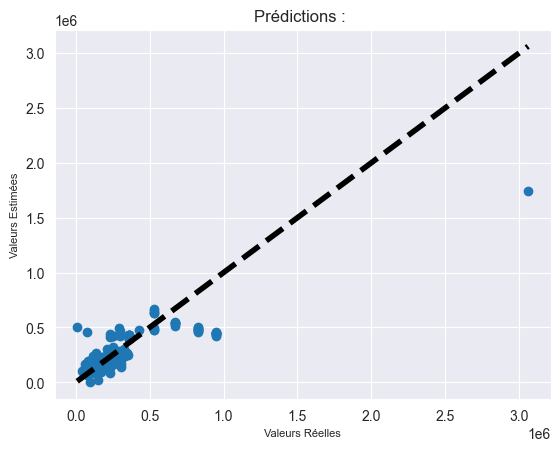

In [1055]:
Lasso.fit(X_train, Y_train)
Y_final = Lasso.predict(X_test)
r2 = met.r2_score(Y_test, Y_final)
a = Lasso.coef_
b = Lasso.intercept_
print('Donc on a : Y =', a, 'X +', b)
print(r2)


fig, ax = plt.subplots()
ax.scatter(Y_test, Y_final)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Valeurs Réelles', fontsize=8)
ax.set_ylabel('Valeurs Estimées', fontsize=8)
ax.set_title('Prédictions : ')
plt.show()

On peut remarquer que les 2 méthodes sont équivalentes pour les résultats. On peut donc commencer à programmer l'algorithme.